**Part 1:**

In [2]:
import warnings 

# Settings the warnings to be ignored 
warnings.filterwarnings('ignore') 

In [5]:
from pyspark.sql import SparkSession
spark=SparkSession.builder.getOrCreate()
sc=spark.sparkContext


In [6]:
data=spark.read.csv('rel.csv', header=False)
data.take(5)

[Row(_c0='C0005790', _c1='C0005778'),
 Row(_c0='C1255279', _c1='C3537249'),
 Row(_c0='C1255446', _c1='C0002520'),
 Row(_c0='C1255552', _c1='C0596019'),
 Row(_c0='C1254417', _c1='C0004611')]

In [7]:
#1. Order the pair of strings alphabetically.
from pyspark.sql.functions import col, when, lit
df_ordered = data.select(
    when(col("_c0") <= col("_c1"), col("_c0")).otherwise(col("_c1")). alias("c0"),
    when(col("_c0") > col("_c1"), col("_c0")).otherwise(col("_c1")). alias("c1"))
df_ordered.show()


+--------+--------+
|      c0|      c1|
+--------+--------+
|C0005778|C0005790|
|C1255279|C3537249|
|C0002520|C1255446|
|C0596019|C1255552|
|C0004611|C1254417|
|C0004611|C1254418|
|C0004611|C1254394|
|C0004611|C1254416|
|C0004611|C1254377|
|C0004611|C1254387|
|C0010640|C0523590|
|C0443720|C1255261|
|C0002520|C0546634|
|C0012854|C0200906|
|C0060323|C1255222|
|C0004611|C1254386|
|C0002520|C0201874|
|C0057522|C0523603|
|C0004611|C1254465|
|C0004358|C0200555|
+--------+--------+
only showing top 20 rows



In [ ]:
#2.  Count number of instances for each ordered pair resulted in Step 1
import shutil
import os
df_counts = df_ordered.groupBy(["c0", "c1"]).count()
df_counts = df_counts.orderBy(["c0", "c1"])
df_counts_rdd = df_counts.rdd.map(lambda row: ','.join(map(str, row)))
filepath='pair-count.txt'
if os.path.exists(filepath):
     shutil.rmtree(filepath)
df_counts_rdd.coalesce(1).saveAsTextFile(path=filepath)



In [11]:
#3. Count the total number of ordered pairs
df_counts.distinct().count()

12946540

**Part 2**

In [58]:
#1. Remove the rows where the column “BloodPressure”, “BMI” or “Glucose” is zero
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, StringType
diabetesSchema = StructType([
    StructField("Pregnancies", IntegerType(), True), 
    StructField("Glucose", IntegerType(), True),
    StructField("BloodPressure", IntegerType(), True),
    StructField("SkinThickness", IntegerType(), True),
    StructField("Insulin", IntegerType(), True),
    StructField("BMI", FloatType(), True),
    StructField("DiabetesPedigreeFunction", FloatType(), True),
    StructField("Age", IntegerType(), True),
    StructField("Outcome", IntegerType(), True) 
])

diabetes=spark.read.csv('diabetes.csv', header=True, schema=diabetesSchema)
filter_df=diabetes.filter((col("BloodPressure") != 0) & 
    (col("BMI") != 0) &
    (col("Glucose") != 0))


In [59]:
#2. Convert the categorical column “Pregnancies” into one-hot encoding
from pyspark.ml import feature as ft
from pyspark.ml import Pipeline
encoder=ft.OneHotEncoder(inputCol='Pregnancies',
                         outputCol= 'Pregnancies_vec')
#pipeline=Pipeline(stages=[encoder])
emodel=encoder.fit(filter_df)
filterTr=emodel.transform(filter_df)
filterTr.select('Pregnancies_vec').show()


+---------------+
|Pregnancies_vec|
+---------------+
| (17,[6],[1.0])|
| (17,[1],[1.0])|
| (17,[8],[1.0])|
| (17,[1],[1.0])|
| (17,[0],[1.0])|
| (17,[5],[1.0])|
| (17,[3],[1.0])|
| (17,[2],[1.0])|
| (17,[4],[1.0])|
|(17,[10],[1.0])|
|(17,[10],[1.0])|
| (17,[1],[1.0])|
| (17,[5],[1.0])|
| (17,[0],[1.0])|
| (17,[7],[1.0])|
| (17,[1],[1.0])|
| (17,[1],[1.0])|
| (17,[3],[1.0])|
| (17,[8],[1.0])|
| (17,[7],[1.0])|
+---------------+
only showing top 20 rows



In [63]:
#3. Create a single column with all the features collated together using VectorAssembler
input_columns = ['Pregnancies_vec', 'Glucose', 'BloodPressure', 'SkinThickness', 
                 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
featureCreator=ft.VectorAssembler(inputCols=input_columns, outputCol="features")
res=featureCreator.transform(filterTr)
res.take(2)

[Row(Pregnancies=6, Glucose=148, BloodPressure=72, SkinThickness=35, Insulin=0, BMI=33.599998474121094, DiabetesPedigreeFunction=0.6269999742507935, Age=50, Outcome=1, Pregnancies_vec=SparseVector(17, {6: 1.0}), features=SparseVector(24, {6: 1.0, 17: 148.0, 18: 72.0, 19: 35.0, 21: 33.6, 22: 0.627, 23: 50.0})),
 Row(Pregnancies=1, Glucose=85, BloodPressure=66, SkinThickness=29, Insulin=0, BMI=26.600000381469727, DiabetesPedigreeFunction=0.35100001096725464, Age=31, Outcome=0, Pregnancies_vec=SparseVector(17, {1: 1.0}), features=SparseVector(24, {1: 1.0, 17: 85.0, 18: 66.0, 19: 29.0, 21: 26.6, 22: 0.351, 23: 31.0}))]

In [82]:
#4. Split training and testing datasets
from pyspark.sql import functions as func
from pyspark.sql import types as typ
filter_df=filter_df.withColumn('Outcome',func.col('Outcome').cast(typ.DoubleType()))
filter_df_train, filter_df_test=filter_df \
    .randomSplit([0.7,0.3],seed=2017)

In [83]:
#5. Implement a random forest classifier and specify the number of decision trees as 20.
from pyspark.ml.classification import RandomForestClassifier
RandomF=RandomForestClassifier(numTrees=20, labelCol='Outcome')
pipeline=Pipeline(stages=[
    encoder,
    featureCreator,
    RandomF
])
model=pipeline.fit(filter_df_train)
testmodel=model.transform(filter_df_test)
testmodel.take(1)

[Row(Pregnancies=0, Glucose=57, BloodPressure=60, SkinThickness=0, Insulin=0, BMI=21.700000762939453, DiabetesPedigreeFunction=0.7350000143051147, Age=67, Outcome=0.0, Pregnancies_vec=SparseVector(17, {0: 1.0}), features=SparseVector(24, {0: 1.0, 17: 57.0, 18: 60.0, 21: 21.7, 22: 0.735, 23: 67.0}), rawPrediction=DenseVector([15.6008, 4.3992]), probability=DenseVector([0.78, 0.22]), prediction=0.0)]

In [84]:
#6. Evaluate the performance
import pyspark.ml.evaluation as ev
evaluator=ev.BinaryClassificationEvaluator(
    rawPredictionCol='probability',
    labelCol='Outcome')
print('AuROC',evaluator.evaluate(testmodel, {evaluator.metricName: 'areaUnderROC'}))
print('AuPR', evaluator.evaluate(testmodel,{evaluator.metricName:'areaUnderPR'}))

AuROC 0.8527020072053532
AuPR 0.6639634735334004


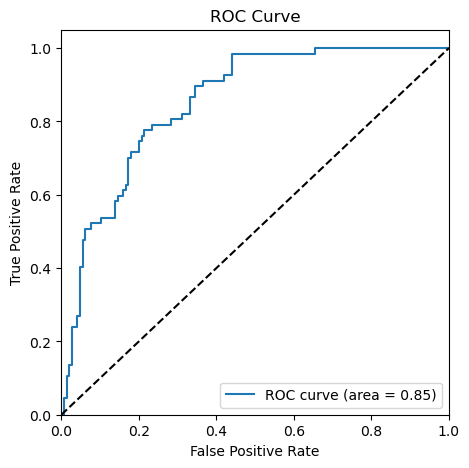

In [85]:
# Retrieve probability and outcome
import sklearn.metrics as sk_me
import numpy as np
import matplotlib.pyplot as plt
probArr=testmodel.select('probability','Outcome')\
    .rdd\
    .map(lambda row:[row[0][1],row[1]]).collect()
probArr=np.array(probArr)

fpr, tpr, thresholds = sk_me.roc_curve(probArr[:,1],probArr[:,0],pos_label=1)
roc_auc = sk_me.auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr,label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
